# Exercise 08
## Lars Kühmichel, Nicolas Wolf

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [13]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

## Task 1: Discrete-time non-linear dynamics: fixed points and stability

In [14]:
def f(x, a, b):
    return a * x + b * np.tanh(x)

### 1. Plot the return plot of this map for the given parameter sets.

In [ ]:
params = [
    dict(a=1.0, b=3.0),
    dict(a=0.5, b=-2.0),
    dict(a=0.5, b=3.0),
    dict(a=1.0, b=0.0),
]

fig, axes = plt.subplots(2, 2)

for i, p in enumerate(params):
    a, b = p.values()
    x = np.linspace(-8, 8, 1000)
    index = np.unravel_index(i, (2,2))
    axes[index].plot(x, f(x, a, b))
    axes[index].plot(x, x, "--", color="k")
    
    axes[index].grid()
    axes[index].set_title(f"a = {a}, b = {b}")
    axes[index].set_xlabel("$x_t$")
    axes[index].set_ylabel("$x_{t+1}=f(x_t,a,b)$")
    
fig.tight_layout()

### By inspecting the plot, how many fixed points do you expect the system to have? Comment on the stability.

Each of these functions has a fixed point at $x=0$. For the parameters $(a, b) = (1, 3)$ and $(.5, 3)$ this fixed point is unstable, while  it will lead to cycles for $(.5, -2)$.

For $(.5, 3)$ there are two additional stable fixed points at $x\approx\pm6$

The parameters $(1, 0)$ will result in the function
$$
x_{t+1} = f(x_t, 1, 0) = x_t.
$$
Therefore every point is a stable fixed point

### 2. For all parameter sets, plot the trajectory starting from different initial conditions

In [ ]:
def time_series(f, x0, steps, *args, **kwargs):
    x = [x0]
    for _ in range(steps):
        xt = f(x[-1], *args, **kwargs)
        x.append(xt)

    return np.array(x)

In [ ]:
x0s = [-10.0, -0.5, 0, 0.5, 10.0]

data = {}

for x0 in x0s:
    for p in params:
        a, b = p.values()
        title = f"{x0:.1f}, {a:.1f}, {b:.1f}"

        data[title] = time_series(f, x0, steps, **p)

In [ ]:
nrows = int(np.ceil(np.sqrt(len(data))))
ncols = int(np.ceil(len(data) / nrows))

plt.subplots(nrows, ncols, sharex="all", dpi=200)

for i, (title, x) in enumerate(data.items()):
    plt.subplot(nrows, ncols, i + 1)
    sns.scatterplot(data=x, s=2.0)
    sns.lineplot(data=x, linewidth=0.25, alpha=0.5, color="black")
    plt.title(title, dict(fontsize=6))
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)

plt.tight_layout()

For the parameters $(1,3)$ the trajectory diverges, unless it starts exactly at the unstable fixed point at $x=0$.

In the second case $(.5, -2)$ one can see, that the trajectory gets on the cycle between $\approx\pm1$, independent of the distance from the unstable fixed point at $x=0$.

The function with $(.5, 3)$ has two stable fixed points, to which the trajectory will converge (unless starting at $x=0$).

The fourth case is a line attractor. Therefore all trajectories stay at the initial condition.

### 3. Confirm your intuitions by computing the fixed points numerically, and their stability analytically.

In [ ]:
# use parameter set III
a = 0.5
b = 3

In [ ]:
import scipy.optimize as optimize
import scipy.signal as signal


def get_fixed_points(f, xmin, xmax, max_points=1000, tol=None, args=()):
    """ Find all fixed points f(x) = x in the interval [xmin, xmax] by iteration """
    if tol is None:
        # auto-determine tolerance
        tol = (xmax - xmin) / max_points

    fixed_points = []
    x0s = np.linspace(xmin, xmax, max_points)

    for x0 in x0s:
        fp, info, ier, msg = optimize.fsolve(lambda x: f(x, *args) - x, x0=x0, full_output=True)
        if ier == 1:
            # found a solution
            fixed_points.append(fp)

    fixed_points = np.squeeze(fixed_points)

    fixed_points, mult = signal.unique_roots(fixed_points, tol=tol)

    return fixed_points

In [ ]:
fixed_points = get_fixed_points(f, -10, 10, args=(a, b))

fixed_points

We find that $f(x, a=0.5, b=3)$ has 2 non-trivial fixed points, as previously suggested.

For this parameter set, we have

$$
f' = \frac{df}{dx} = 3 \operatorname{sech}^2(x) + 0.5
$$

A fixed point $x_f$ is stable, if $\vert f'(x_f) \vert < 1$. Here, we have $f'(-6) = f'(6) \approx 0.5$, so both fixed points are stable. The fixed point at $x=0$ is unstable, since $|f'(0)|=3.5$.

In [1001]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [1002]:
def make_data(N, T, Tinp, Tout):
    input1 = np.zeros([T, 1, N], dtype=np.float32)
    input2 = np.zeros([T, 1, N], dtype=np.float32)
    input1[Tinp, 0, 0] = 1
    input2[Tinp, 0, 1] = 1

    target1 = np.zeros([T, 1, N], dtype=np.float32)
    target2 = np.zeros([T, 1, N], dtype=np.float32)

    """
    Either the sample code or the sheet mixes up the targets.
    We swap them in the code, so it is consistent with the sheet.
    This code also incorrectly utilizes Tout instead of t, so we fixed that too.
    """

    """
    INCORRECT (SAMPLE) CODE:

    for t in Tout:
        target1[Tout, 0, 3] = 1
        target2[Tout, 0, 2] = 1
    """

    # CORRECT CODE:
    for t in Tout:
        target1[t, 0, 2] = 1
        target2[t, 0, 3] = 1

    # instead of a dict, we make a tensor
    with torch.no_grad():
        input1, input2 = torch.from_numpy(input1), torch.from_numpy(input2)
        target1, target2 = torch.from_numpy(target1), torch.from_numpy(target2)
        inputs = torch.stack((input1, input2), dim=0)
        targets = torch.stack((target1, target2), dim=0)


    return inputs, targets

In [1003]:
def draw_batch(inputs: torch.Tensor, targets: torch.Tensor, size: int):
    num_trial_types, T, _, N = inputs.shape

    x = inputs.new_zeros(T, size, N)
    y = targets.new_zeros(T, size, N)
    for sample in range(size):
        trial_type = np.random.randint(0, num_trial_types)
        # x[:, sample, :] = torch.tensor(inputs[trial_type].clone().detach().numpy(), dtype=torch.float32).squeeze()
        # y[:, sample, :] = torch.tensor(targets[trial_type].clone().detach().numpy(), dtype=torch.float32).squeeze()
        x[:, sample, :] = inputs[trial_type].clone().detach().requires_grad_(inputs.requires_grad).squeeze()
        y[:, sample, :] = targets[trial_type].clone().detach().requires_grad_(targets.requires_grad).squeeze()

    return x, y

In [1004]:
def train(net: nn.Module, inputs: torch.Tensor, targets: torch.Tensor, epochs: int, batch_size: int, optimizer: optim.Optimizer, criterion: nn.Module, Tout: int, device="cuda"):
    train_loss = []

    for epoch in tqdm(range(epochs)):
        x, y = draw_batch(inputs, targets, batch_size)
        x = x.to(device)
        y = y.to(device)

        yhat, _ = net(x)

        loss = criterion(yhat[Tout, :, 2:4], y[Tout, :, 2:4])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.detach().cpu().numpy())

    return train_loss

In [1005]:
def plot(net, losses, inputs, device="cuda"):
    plt.figure(figsize=plt.figaspect(1.5), dpi=150)
    plt.subplot(3, 1, 1)
    plt.plot(losses, linewidth=1)
    plt.title("Loss")

    for i, x in enumerate(inputs):
        x = x.to(device)

        yhat, _ = net(x)
        yhat = yhat.cpu().detach().numpy()
        x3 = np.squeeze(yhat[:, 0, 2])
        x4 = np.squeeze(yhat[:, 0, 3])
        plt.subplot(3, 1, i + 2)
        plt.plot(x3, linewidth=1, label="$x_t^{(3)}$")
        plt.plot(x4, linewidth=1, label="$x_t^{(4)}$")

        # replace multiple horizontal line plots with single more sensible plt call
        line_y = [0, 1]
        for y in line_y:
            plt.axhline(y=y, color="black", linestyle="--", linewidth=1, alpha=0.5)

        plt.axvline(x=Tinp, color="green", linestyle="--", linewidth=1, alpha=0.5, label="Input Time")

        for t in Tout:
            plt.axvline(x=t, color="red", linestyle="--", linewidth=1, alpha=0.5, label="Output Time")

        plt.title(f"Network Outputs for Signal {i + 1}")
        plt.xlabel("t")
        plt.ylabel("outputs")
        plt.ylim(-0.5, 1.5)
        plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")

    plt.tight_layout()

### For N = 5, examine the convergence of the error function for different learning rates.

$\alpha \approx 0.01$ or $0.1$ is likely optimal. The network converges to near zero training loss for these learning rates. This also means it likely overfits badly. For smaller $\alpha$, the network does not yet converge (or converges to a poor local minimum). For $\alpha = 1$, the network diverges.

  0%|          | 0/6000 [00:00<?, ?it/s]

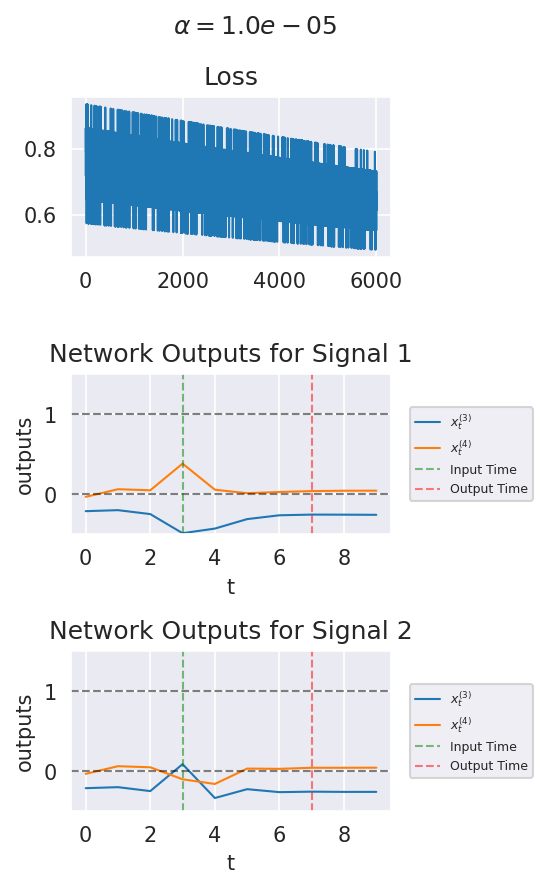

  0%|          | 0/6000 [00:00<?, ?it/s]

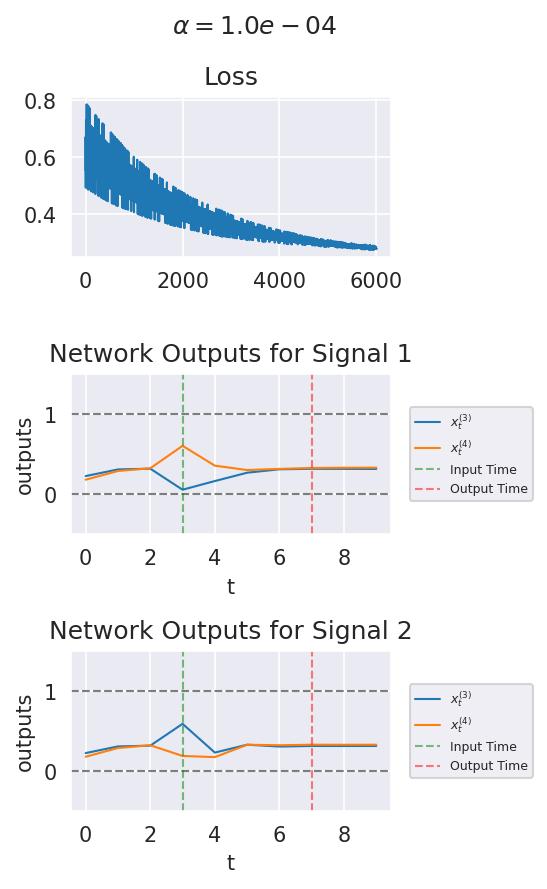

  0%|          | 0/6000 [00:00<?, ?it/s]

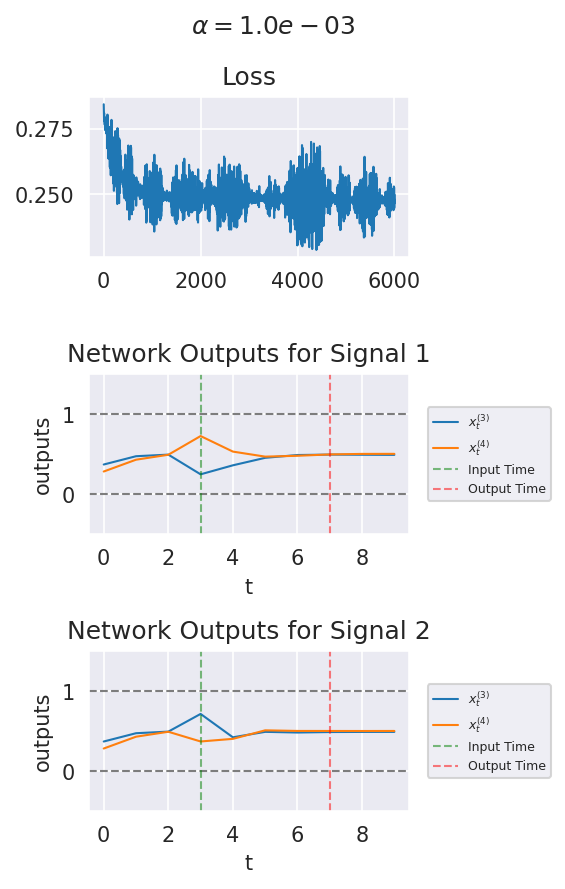

  0%|          | 0/6000 [00:00<?, ?it/s]

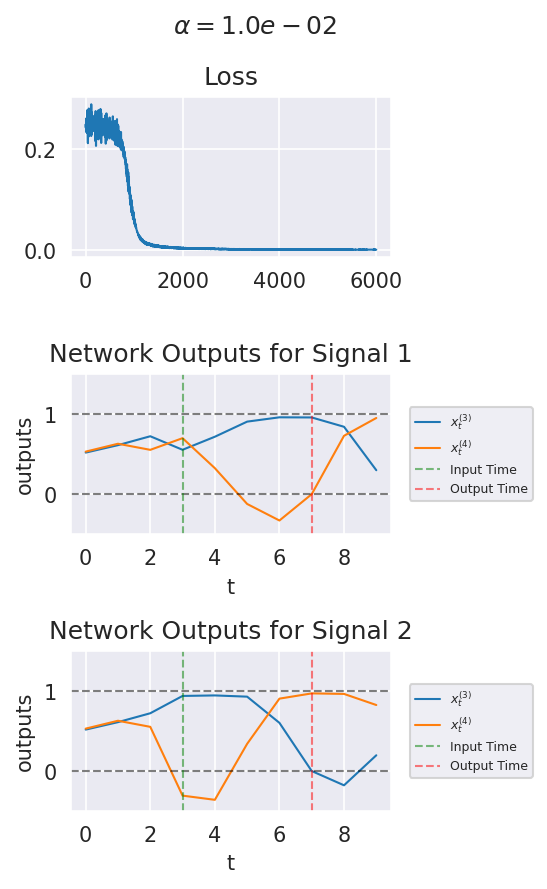

  0%|          | 0/6000 [00:00<?, ?it/s]

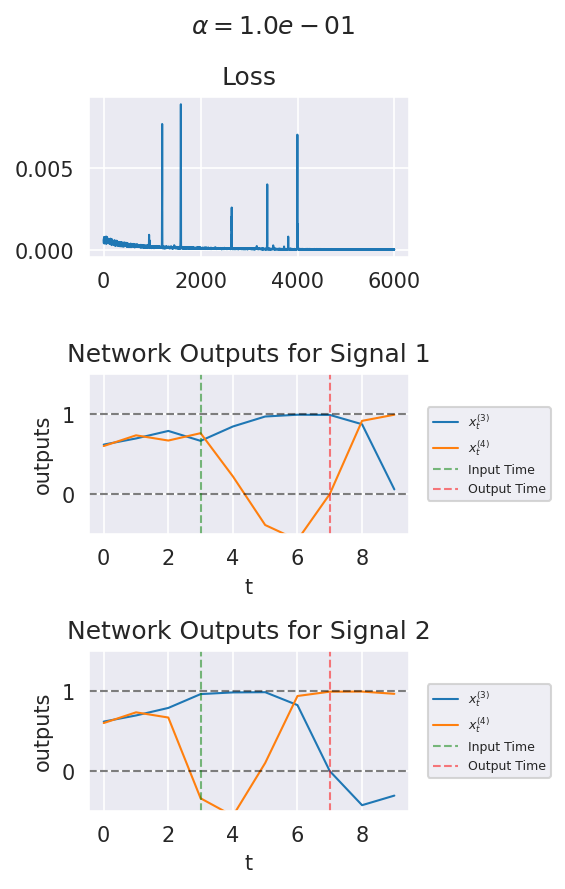

  0%|          | 0/6000 [00:00<?, ?it/s]

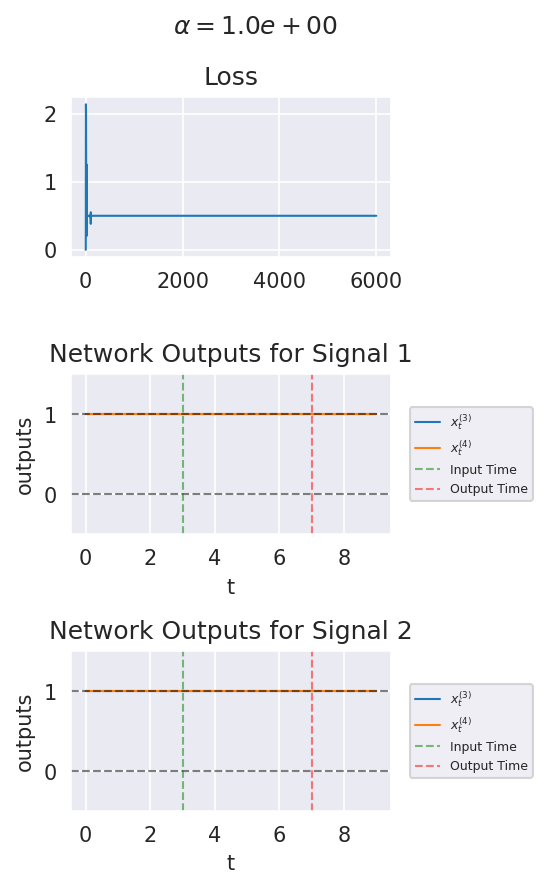

In [1006]:
T = 10  # Length of time series
Tinp = 3  # Time at which the input is presented
Tout = [7]  # Time points at which the output is required
N = 5  # Number of neurons
Ntrial = 6000  # Number of trials
alphas = np.logspace(-5, 0, 6)
batchsize = 5  # how many trials per training step?

# Create 1 layer RNN with N neurons
# Inputs to RNN:
# No. of input units, No. of total units, No. of layers, nonlinearity
net = nn.RNN(N, N, 1, nonlinearity='tanh').cuda()
# net = nn.RNN(N, N, 1, nonlinearity='relu')

for alpha in alphas:
    optimizer = optim.SGD(net.parameters(), lr=alpha)
    criterion = nn.MSELoss()

    inputs, targets = make_data(N, T, Tinp, Tout)
    train_losses = train(net, inputs, targets, Ntrial, batchsize, optimizer, criterion, Tout)
    plot(net, train_losses, inputs)
    plt.suptitle(rf"$\alpha = {alpha:.1e}$")
    plt.tight_layout()
    plt.show()

### Compare that to training in networks with $N = 10$ units.

We have effectively  the same result. $\alpha = 0.001$ is converging a little better here, but this could be due to random initialization.

  0%|          | 0/6000 [00:00<?, ?it/s]

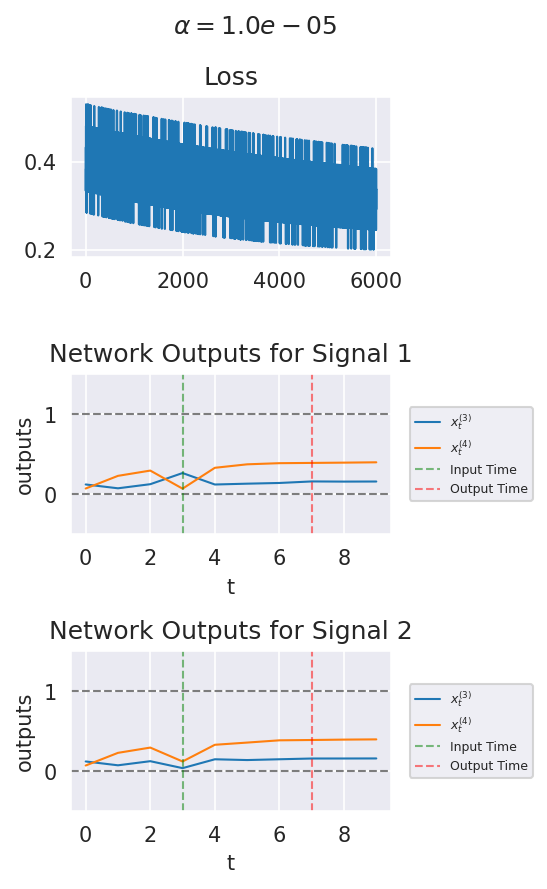

  0%|          | 0/6000 [00:00<?, ?it/s]

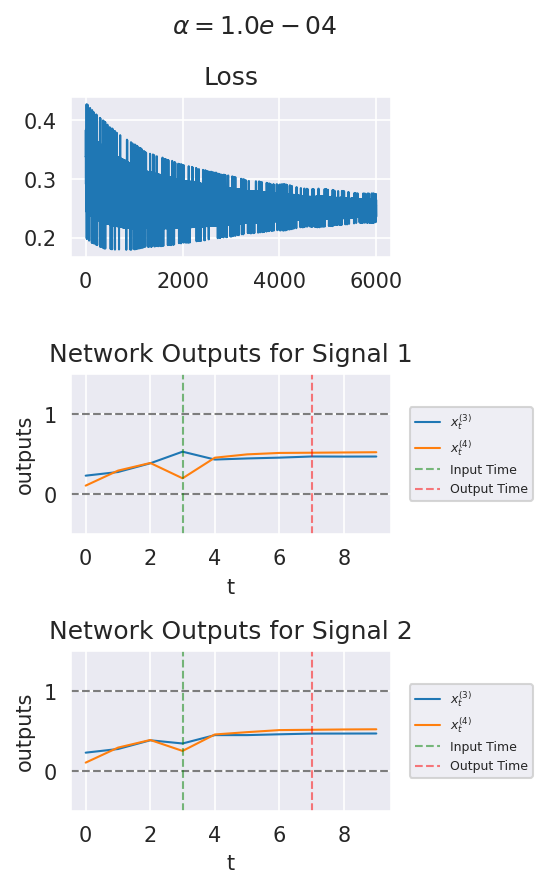

  0%|          | 0/6000 [00:00<?, ?it/s]

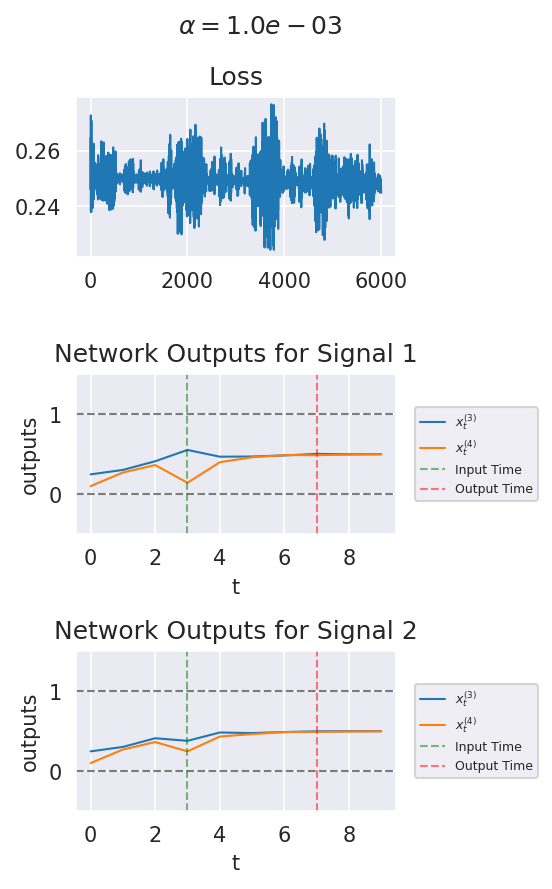

  0%|          | 0/6000 [00:00<?, ?it/s]

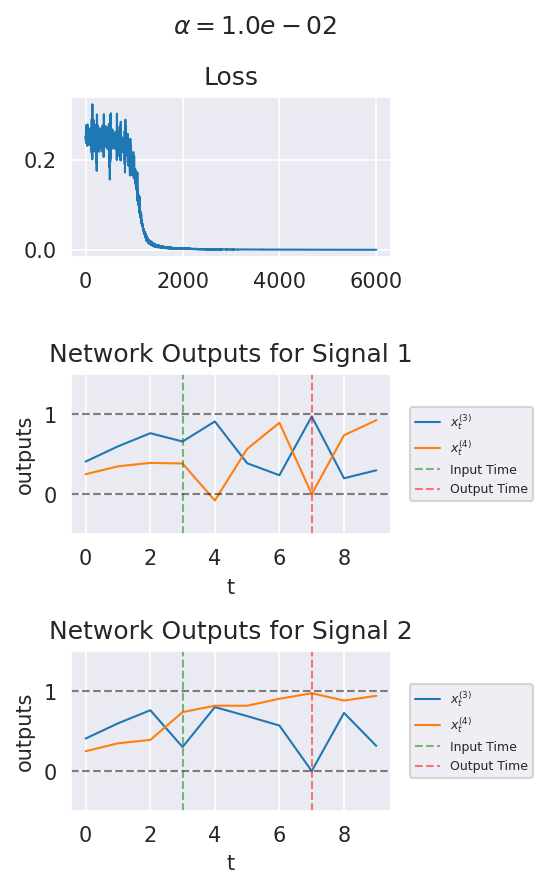

  0%|          | 0/6000 [00:00<?, ?it/s]

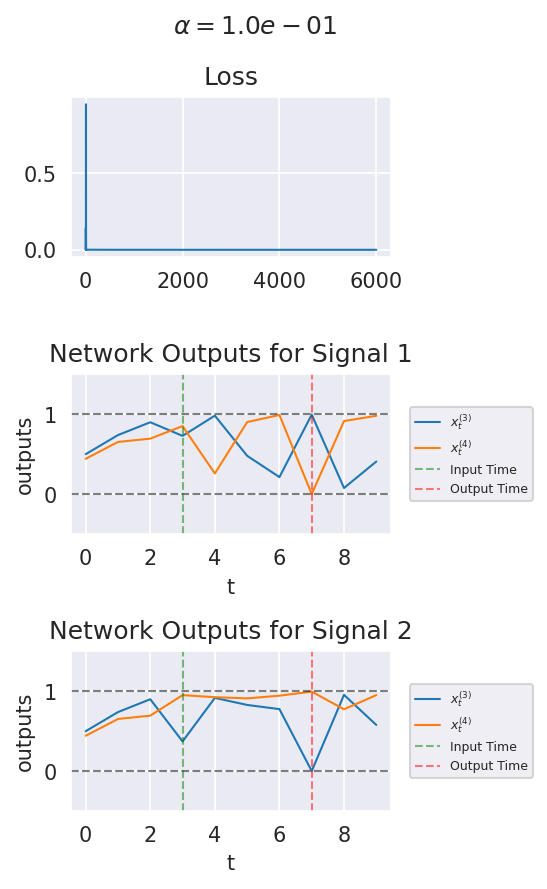

  0%|          | 0/6000 [00:00<?, ?it/s]

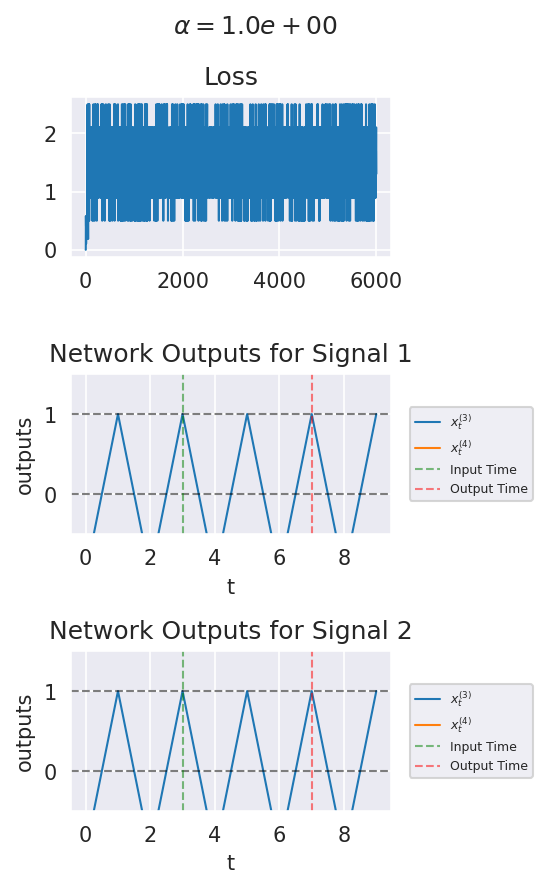

In [1007]:
N = 10

# Create 1 layer RNN with N neurons
# Inputs to RNN:
# No. of input units, No. of total units, No. of layers, nonlinearity
net = nn.RNN(N, N, 1, nonlinearity='tanh').cuda()
# net = nn.RNN(N, N, 1, nonlinearity='relu')

for alpha in alphas:
    optimizer = optim.SGD(net.parameters(), lr=alpha)
    criterion = nn.MSELoss()

    inputs, targets = make_data(N, T, Tinp, Tout)
    train_losses = train(net, inputs, targets, Ntrial, batchsize, optimizer, criterion, Tout)
    plot(net, train_losses, inputs)
    plt.suptitle(rf"$\alpha = {alpha:.1e}$")
    plt.tight_layout()
    plt.show()

### Change the activation function to ReLU and do a comparison.

For $N = 5$, the results are significantly worse. None of the networks converge.

  0%|          | 0/6000 [00:00<?, ?it/s]

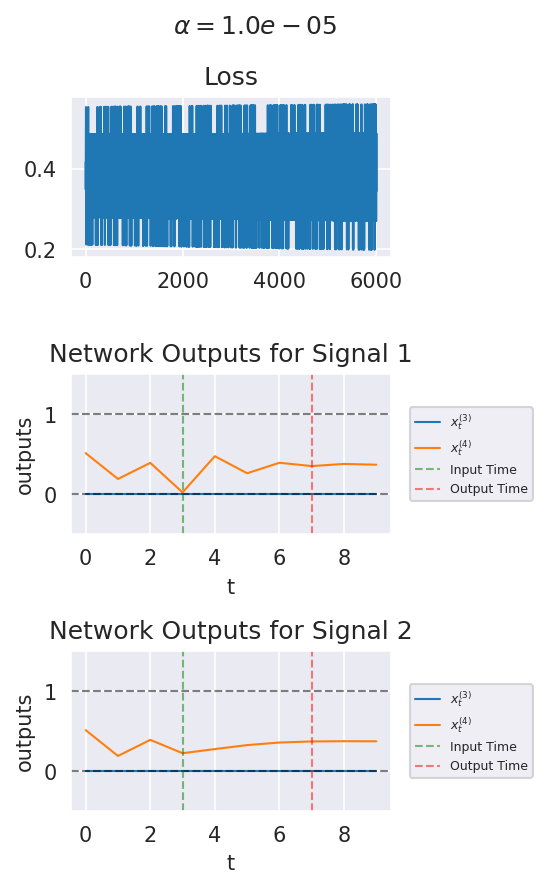

  0%|          | 0/6000 [00:00<?, ?it/s]

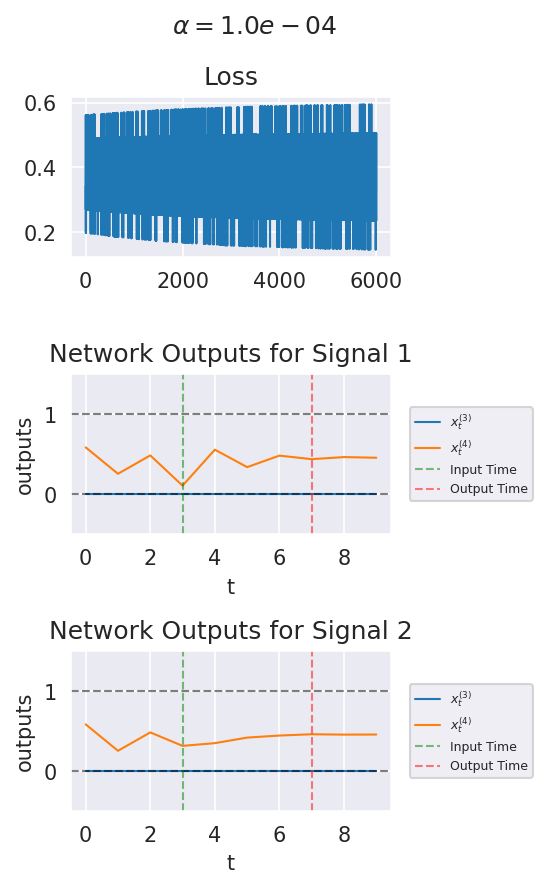

  0%|          | 0/6000 [00:00<?, ?it/s]

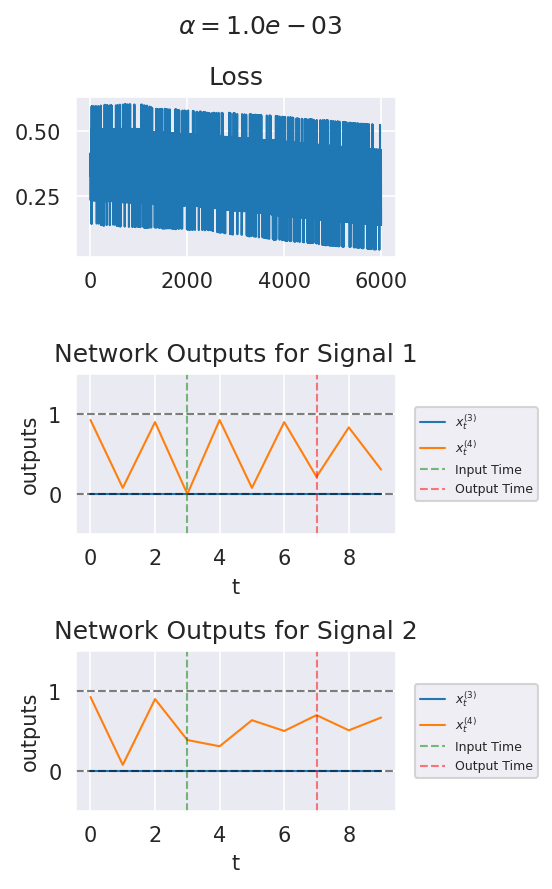

  0%|          | 0/6000 [00:00<?, ?it/s]

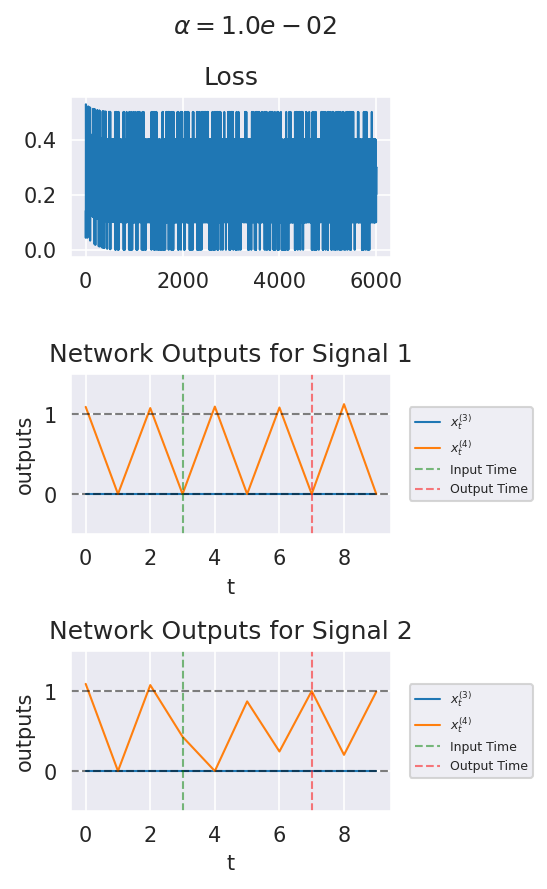

  0%|          | 0/6000 [00:00<?, ?it/s]

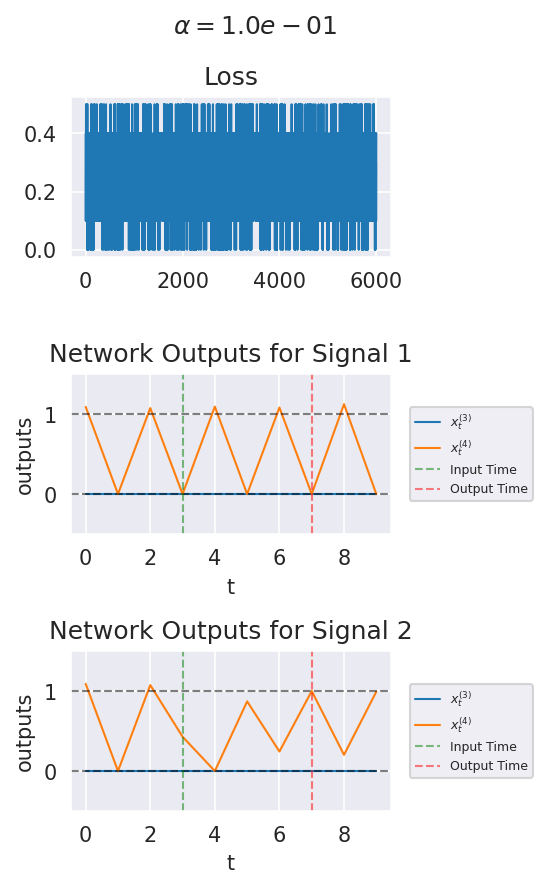

  0%|          | 0/6000 [00:00<?, ?it/s]

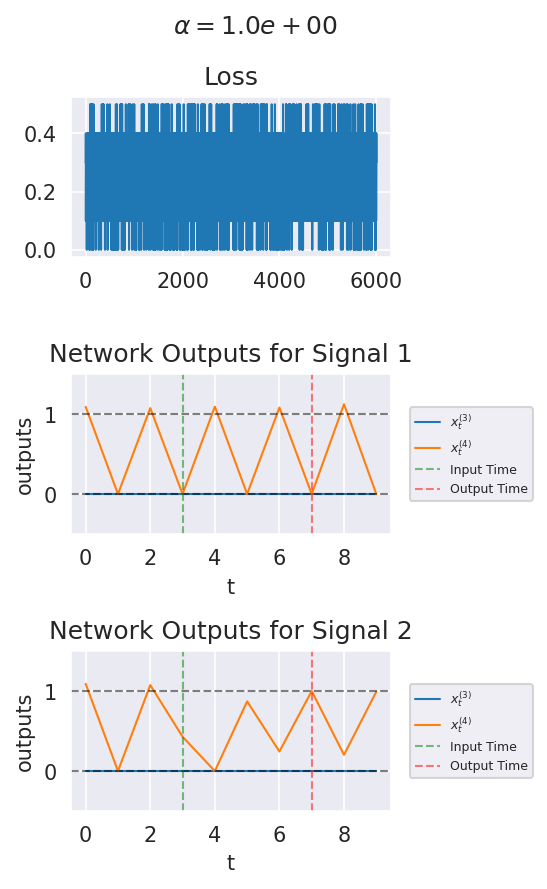

In [1008]:
N = 5

# Create 1 layer RNN with N neurons
# Inputs to RNN:
# No. of input units, No. of total units, No. of layers, nonlinearity
net = nn.RNN(N, N, 1, nonlinearity="relu").cuda()

for alpha in alphas:
    optimizer = optim.SGD(net.parameters(), lr=alpha)
    criterion = nn.MSELoss()

    inputs, targets = make_data(N, T, Tinp, Tout)
    train_losses = train(net, inputs, targets, Ntrial, batchsize, optimizer, criterion, Tout)
    plot(net, train_losses, inputs)
    plt.suptitle(rf"$\alpha = {alpha:.1e}$")
    plt.tight_layout()
    plt.show()

For $N = 10$, $\alpha = 0.01$ or $0.001$ seems to work well. The training loss is a lot more noisy than for $\tanh$, and the resulting time series show less oscillatory behaviour. Overall, the networks that converged well with ReLU are closer to what a human would draw, compared to $\tanh$.

  0%|          | 0/6000 [00:00<?, ?it/s]

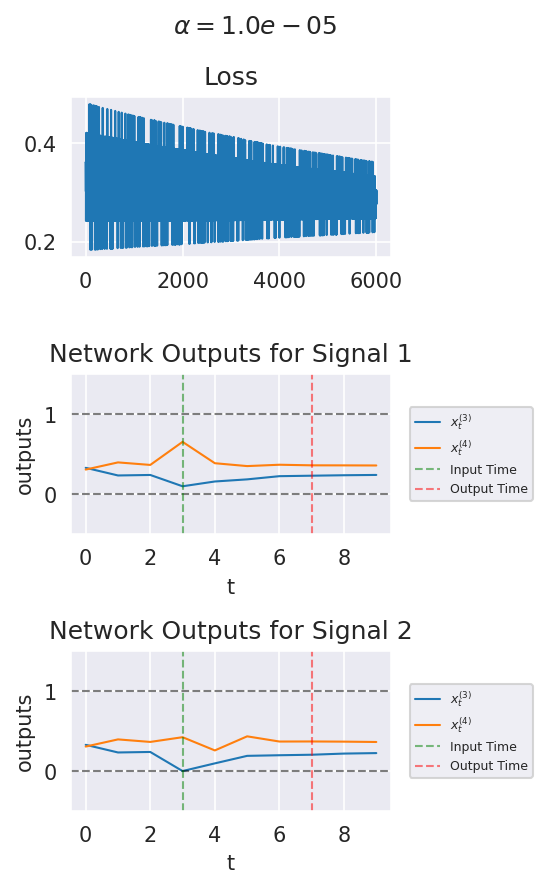

  0%|          | 0/6000 [00:00<?, ?it/s]

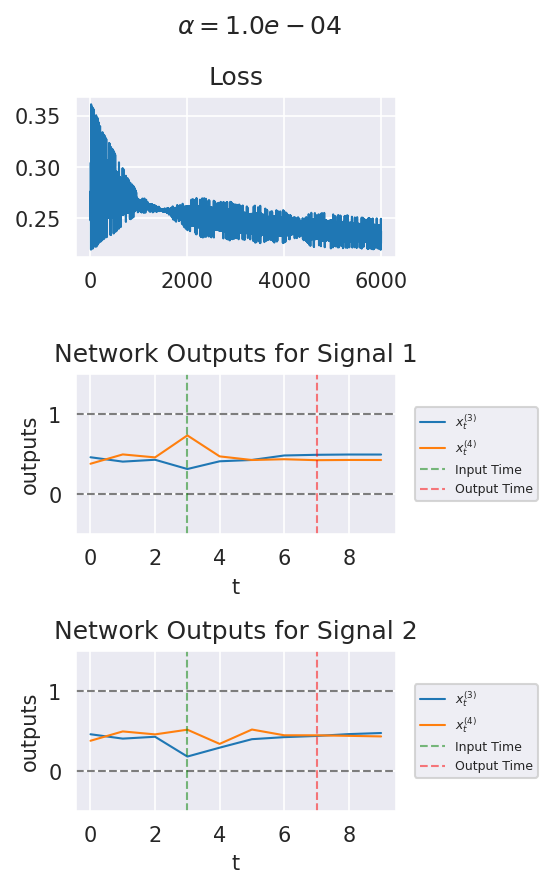

  0%|          | 0/6000 [00:00<?, ?it/s]

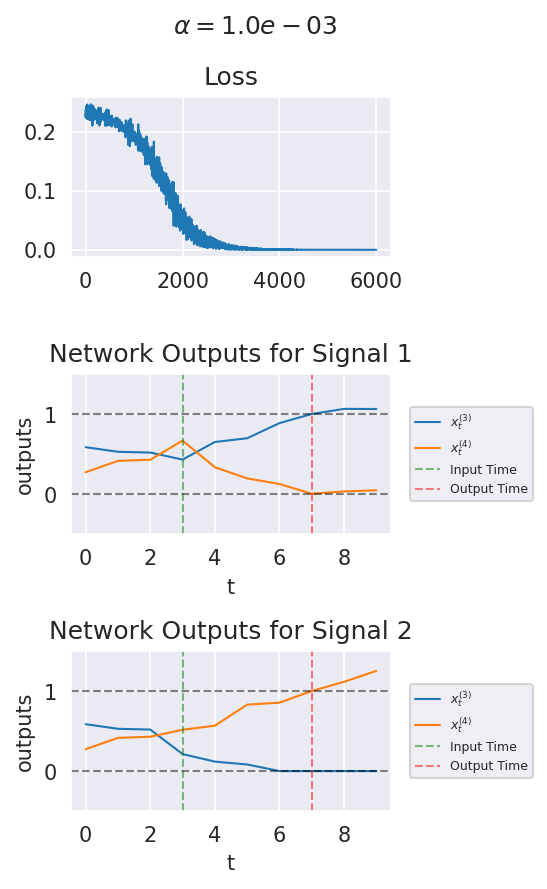

  0%|          | 0/6000 [00:00<?, ?it/s]

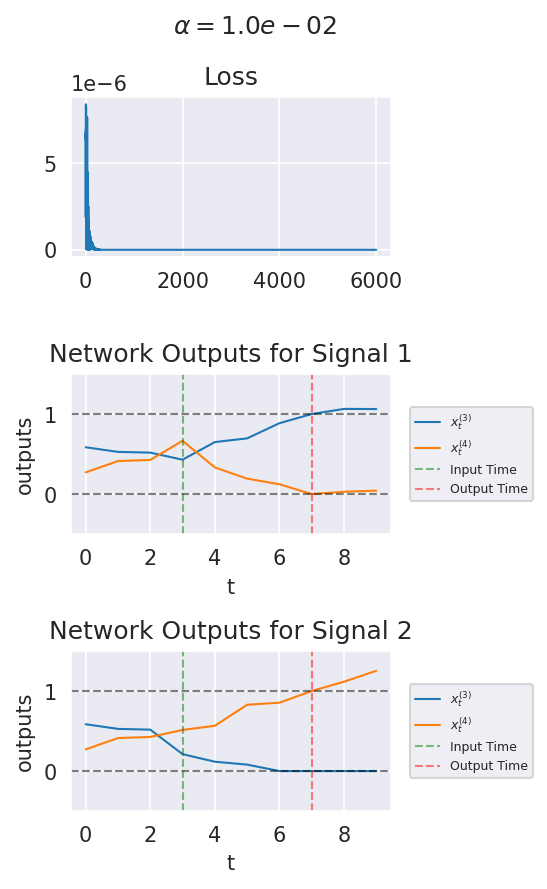

  0%|          | 0/6000 [00:00<?, ?it/s]

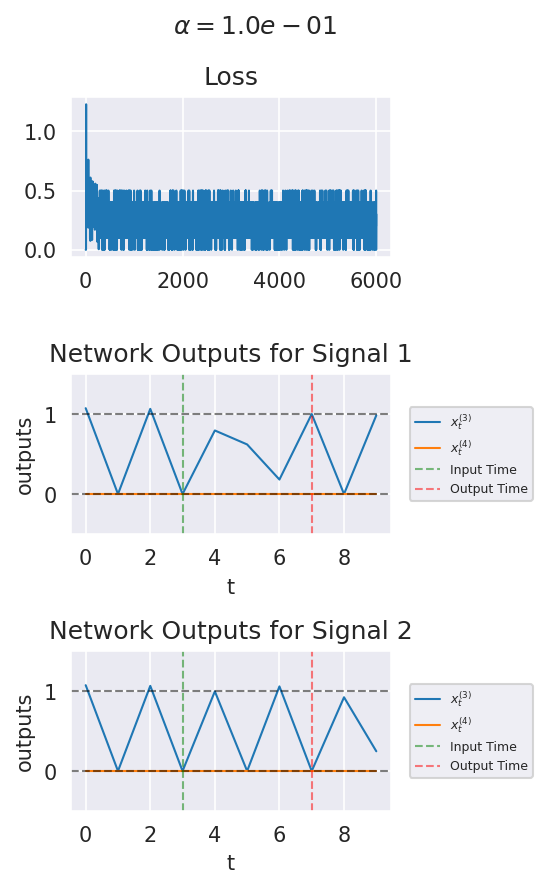

  0%|          | 0/6000 [00:00<?, ?it/s]

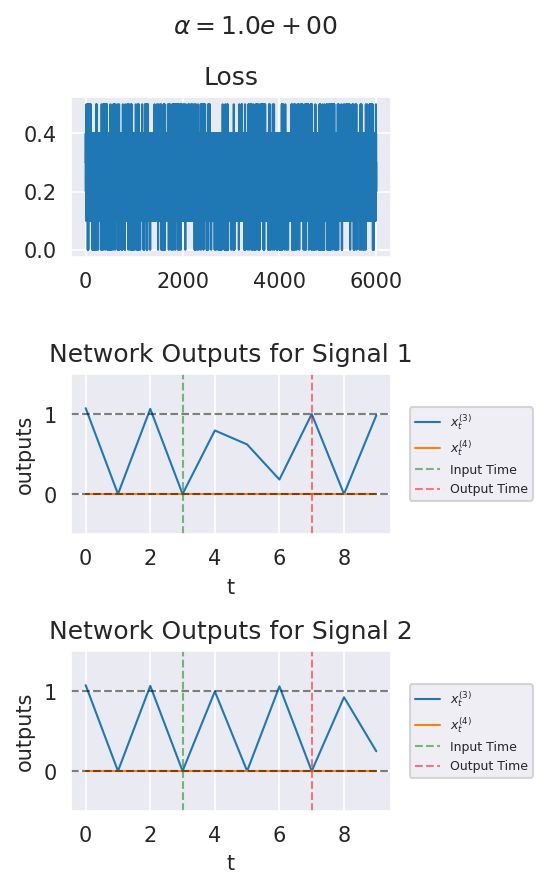

In [1009]:
N = 10

# Create 1 layer RNN with N neurons
# Inputs to RNN:
# No. of input units, No. of total units, No. of layers, nonlinearity
net = nn.RNN(N, N, 1, nonlinearity="relu").cuda()

for alpha in alphas:
    optimizer = optim.SGD(net.parameters(), lr=alpha)
    criterion = nn.MSELoss()

    inputs, targets = make_data(N, T, Tinp, Tout)
    train_losses = train(net, inputs, targets, Ntrial, batchsize, optimizer, criterion, Tout)
    plot(net, train_losses, inputs)
    plt.suptitle(rf"$\alpha = {alpha:.1e}$")
    plt.tight_layout()
    plt.show()